<a id='section_id3'></a>

# Analyse Lastprofile - Lastprofil 31 und 10kWp PV

Verwendete Skripte:\
[Parameter Worst Case](parameter_worst_case.py)\
[Parameter Base Case](parameter_base_case.py)\
[Parameter Best Case](parameter_best_case.py)\
[Hilfsfunktionen](own_utility_functions.py)\
[Visualisierung](visualisation.py)\
[Speicher](speicher.py)


## Formelzeichen

\begin{eqnarray}
P_{pv} &=& Photovoltaikleistung\ in\ W\\
P_{verbraucher} &=& Verbraucherleistung\ in\ W\\
P_{dif} &=& P_{pv}-P_{verbraucher} \ resultierende\ Differenzleistung\ bei\ Eigennutzung\ ohne\ Speicher\ in\ W\ -\ Überschuss\ positiv,\ Defizit\ negativ\\
P_{ueber} &=& Überschussleistung\ in\ W\\
P_{def} &=& Defizitleistung\ in\ W\ (Betrag)\\
\\
eff_{elektrolyse} &=& Wirkungsgrad\ Elektrolyseurs\ (Einspeicherung)\\
eff_{brennstoffzelle} &=& Wirkungsgrad\ Brennstoffzelle\ (Ausspeicherung)\\
eff_{bat} &=& Wirkungsgrad\ Batterie\ (gesamt)\\
\end{eqnarray}


## Initialisierung

In [1]:
from parameter_base_case import *

Nr = '31' 
directory = directory_data+'Lastprofil_' + Nr +'.npy'
with open(directory, 'rb') as f:
    [P_verbraucher, P_pv, P_dif, P_def, P_ueber] = np.load(f)
    
E_verbraucher = jahresenergie_kWh(P_verbraucher)
E_def = jahresenergie_kWh(P_def)
E_ueber = jahresenergie_kWh(P_ueber)

#Zeitausschnitte für Visualisierung
days = timeline.minute_period('2019-09-01 00:00','2019-09-05')
year = timeline.minute_period('2019-01-01','2019-12-31')
year_dayres = timeline.day_period('2019-01-01','2019-12-31')

# -------------------------------------------------------------------------------------------------------------

## Lastprofile Detailansicht

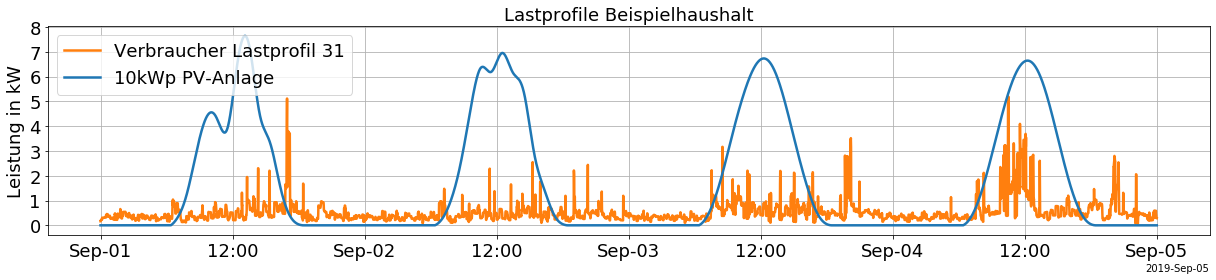

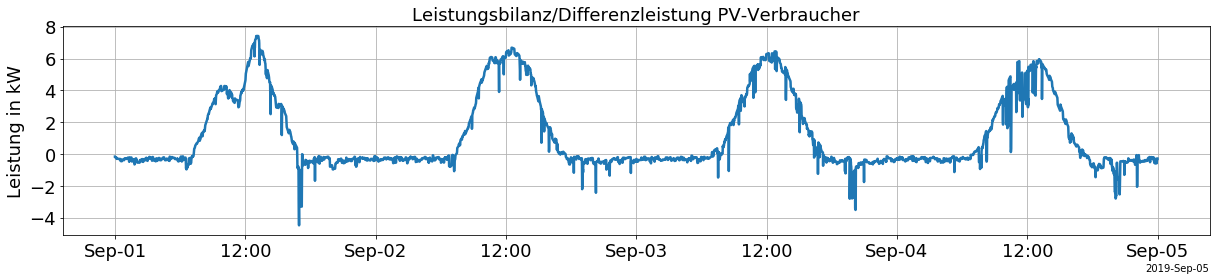

In [2]:
ax=vis.plot_timeline(days,P_verbraucher/1000,'Leistung in kW','Lastprofile Beispielhaushalt',1)
vis.addtoplot_timeline(ax,days,P_pv/1000,['Verbraucher Lastprofil '+Nr,'10kWp PV-Anlage'],'best',0)
vis.save_to_tex('diagramm_ausschnitt_verbraucher_erzeuger',ax)

ax=vis.plot_timeline(days,(P_pv-P_verbraucher)/1000,'Leistung in kW','Leistungsbilanz/Differenzleistung PV-Verbraucher')

Differenz zwischen Verbraucher und PV-Leistung ist ersichtlich. Tagsüber Überschuss, Nachts Defizit

## Tägliche Einspeisung und Netzbezug im Jahresverlauf

in dieser Betrachtung wird die tägliche Überproduktion (ohne Speicher wird die Überproduktion eingespeist) und Defizit (wird ohne Speicher aus dem Netz bezogen) über den Jahresverlauf untersucht.

In [3]:
windowsize_smooth=21 #muss ungerade sein
taegl_defizit = initialize_year_array('D',0)
taegl_ueberschuss = initialize_year_array('D',0)
for i, value in enumerate(P_dif):
    if i%(60*24)== 0:
        taegl_ueberschuss[int(i/60/24)] = np.sum(P_ueber[i-60*24:i])/60/1000
        taegl_defizit[int(i/60/24)] = np.sum(P_def[i-60*24:i])/60/1000
taegl_defizit[0]=15

taegl_ueberschuss_smooth = savgol_filter(taegl_ueberschuss, windowsize_smooth, 3)
ax=vis.plot_timeline(year_dayres, taegl_ueberschuss_smooth,'Energie pro Tag in kWh','Jahresverlauf Überschuss/Defizit \
ohne Speicher für Lastprofil '+Nr)
legend=['Überschuss']
taegl_defizit_smooth = savgol_filter(taegl_defizit, windowsize_smooth, 3)
legend.append('Defizit')
vis.addtoplot_timeline(ax, year_dayres, taegl_defizit_smooth, legend,'upper right')

ax.set_ylim(-5,50)

vis.save_to_tex('diagramm_taegl_ueberschussdefizit'+'_'+file_extension ,ax)

#Saisonalspeicher ideal (auch Effizienz)
E_bilanz=taegl_ueberschuss-taegl_defizit
#vis.plot(E_bilanz)
saisonalueberschuss=np.sum(negval_cutoff(E_bilanz))
saisonaldefizit=np.sum(negval_cutoff(-E_bilanz))
print('verbleibender Überschuss für Saisonalspeicher:',saisonalueberschuss,'kWh')
print('verbleibendes Defizit für Saisonalspeicher:',saisonaldefizit,'kWh')


verbleibender Überschuss für Saisonalspeicher: 5624.22714383315 kWh
verbleibendes Defizit für Saisonalspeicher: 850.6706041057283 kWh


Das tägliche Defizit/Netzbezug ist entscheidend für die Tag-Nacht-Speicher Auslegung. Diese Energiemenge muss durch den Speicher zur verfügung gestellt. Zwischen März und Oktober wäre hier also ein 10kWh Speicher so gut wie immer ausreichend. Während über den Winter der Überschuss nicht ausreicht den Speicher zu füllen.


## Speicher mit idealer Leistung und Kapazität

der Speicher läuft immer mit der geforderten Ein/Ausspeicherleistung um alle Verbraucher zu versorgen und alle Überschüsse einzuspeichern --> Einfluss der Effizienz wird betrachtet



### tägliche Ein/Ausspeicherung:


verbleibender Überschuss für Saisonalspeicher: 2373.0798485323785 kWh
verbleibendes Defizit für Saisonalspeicher: 2994.148213431269 kWh

verbleibender Überschuss für Saisonalspeicher: 5285.981180546574 kWh
verbleibendes Defizit für Saisonalspeicher: 926.8095277260836 kWh


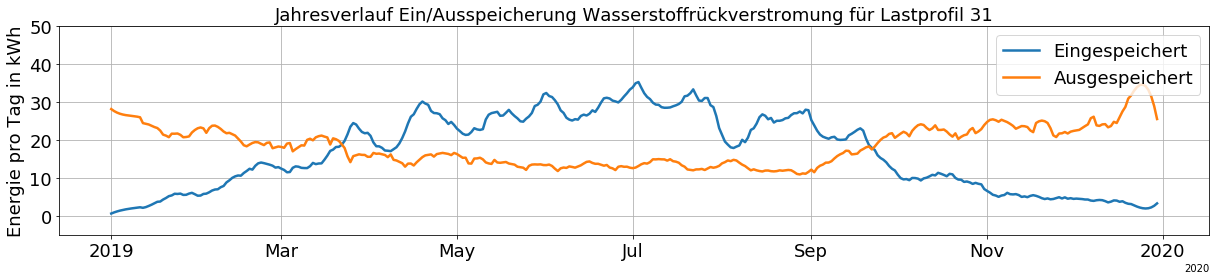

In [4]:
##Wasserstoffrückverstromung
windowsize_smooth=21 #muss ungerade sein
taegl_defizit = initialize_year_array('D',0)
taegl_ueberschuss = initialize_year_array('D',0)
for i, value in enumerate(P_dif):
    if i%(60*24)== 0:
        taegl_ueberschuss[int(i/60/24)] = np.sum(P_ueber[i-60*24:i])/60/1000*eff_elektrolyse
        taegl_defizit[int(i/60/24)] = np.sum(P_def[i-60*24:i])/60/1000/eff_brennstoffzelle
taegl_defizit[0]=15

taegl_ueberschuss_smooth = savgol_filter(taegl_ueberschuss, windowsize_smooth, 3)
ax=vis.plot_timeline(year_dayres, taegl_ueberschuss_smooth,'Energie pro Tag in kWh','Jahresverlauf Ein/Ausspeicherung \
Wasserstoffrückverstromung für Lastprofil '+Nr)
legend=['Eingespeichert']
taegl_defizit_smooth = savgol_filter(taegl_defizit, windowsize_smooth, 3)
legend.append('Ausgespeichert')
vis.addtoplot_timeline(ax, year_dayres, taegl_defizit_smooth, legend,'upper right')

taegl_dif_RFC=taegl_ueberschuss_smooth-taegl_defizit_smooth

ax.set_ylim(-5,50)
vis.save_to_tex('diagramm_taegl_einausspeicherung_RFC'+'_'+file_extension ,ax)

#Saisonalspeicher real mit Idealauslegung
E_bilanz=taegl_ueberschuss-taegl_defizit
#vis.plot(E_bilanz)
saisonalueberschuss=np.sum(negval_cutoff(E_bilanz))
saisonaldefizit=np.sum(negval_cutoff(-E_bilanz))
print('verbleibender Überschuss für Saisonalspeicher:',saisonalueberschuss,'kWh')
print('verbleibendes Defizit für Saisonalspeicher:',saisonaldefizit,'kWh')

##Batteriespeicher
import math
windowsize_smooth=21 #muss ungerade sein
taegl_defizit = initialize_year_array('D',0)
taegl_ueberschuss = initialize_year_array('D',0)
for i, value in enumerate(P_dif):
    if i%(60*24)== 0:
        taegl_ueberschuss[int(i/60/24)] = np.sum(P_ueber[i-60*24:i])/60/1000*math.sqrt(eff_bat)
        taegl_defizit[int(i/60/24)] = np.sum(P_def[i-60*24:i])/60/1000/math.sqrt(eff_bat)
taegl_defizit[0]=15

taegl_ueberschuss_smooth = savgol_filter(taegl_ueberschuss, windowsize_smooth, 3)
ax=vis.plot_timeline(year_dayres, taegl_ueberschuss_smooth,'Energie pro Tag in kWh','Jahresverlauf Ein/Ausspeicherung \
Batteriespeicher für Lastprofil '+Nr)
legend=['Eingespeichert']
taegl_defizit_smooth = savgol_filter(taegl_defizit, windowsize_smooth, 3)
legend.append('Ausgespeichert')
vis.addtoplot_timeline(ax, year_dayres, taegl_defizit_smooth, legend,'upper right')

taegl_dif_bat=taegl_ueberschuss_smooth-taegl_defizit_smooth

ax.set_ylim(-5,50)
vis.save_to_tex('diagramm_taegl_einausspeicherung_bat'+'_'+file_extension ,ax)

#Saisonalspeicher real mit Idealauslegung
E_bilanz=taegl_ueberschuss-taegl_defizit
#vis.plot(E_bilanz)
saisonalueberschuss=np.sum(negval_cutoff(E_bilanz))
saisonaldefizit=np.sum(negval_cutoff(-E_bilanz))
print('verbleibender Überschuss für Saisonalspeicher:',saisonalueberschuss,'kWh')
print('verbleibendes Defizit für Saisonalspeicher:',saisonaldefizit,'kWh')

### Theoretischer Speicherfüllstand:

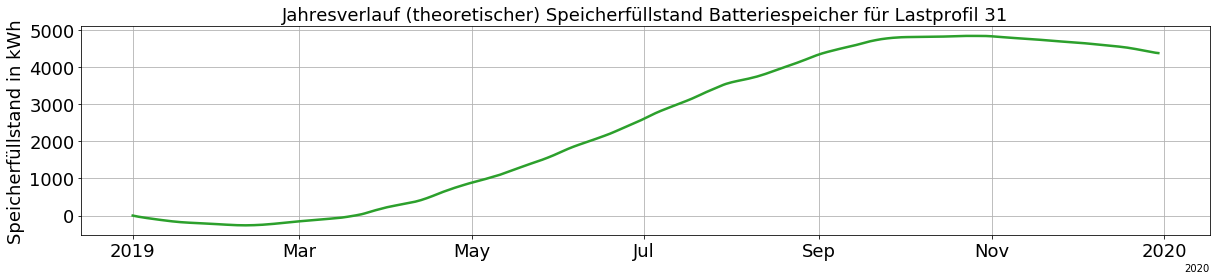

In [5]:
Speicherfuellstand=np.zeros(len(taegl_dif_RFC))
for i,value in enumerate(taegl_dif_RFC):
    if i>0:
        Speicherfuellstand[i]=Speicherfuellstand[i-1]+value
ax=vis.plot_timeline(year_dayres, Speicherfuellstand,'Speicherfüllstand in kWh','Jahresverlauf (theoretischer) Speicherfüllstand \
Wasserstoffrückverstromung für Lastprofil '+Nr,2)

vis.save_to_tex('diagramm_theoretischer_saisonalspeicher_RFC'+'_'+file_extension ,ax)

Speicherfuellstand=np.zeros(len(taegl_dif_bat))
for i,value in enumerate(taegl_dif_bat):
    if i>0:
        Speicherfuellstand[i]=Speicherfuellstand[i-1]+value
ax=vis.plot_timeline(year_dayres, Speicherfuellstand,'Speicherfüllstand in kWh','Jahresverlauf (theoretischer) Speicherfüllstand \
Batteriespeicher für Lastprofil '+Nr,2)

vis.save_to_tex('diagramm_theoretischer_saisonalspeicher_bat'+'_'+file_extension ,ax)

## Validierung Speicherimplementierung

### Wasserstoffrückverstromung 10kW Elektrolyseur 10kW Brennstoffzelle 5000kWh Kapazität 

--> mehr oder weniger keine Limitierung bei Speicherleistung und Kapazität (vgl theoretischer Verlauf oben)
Startbefüllung des tanks wird auf 3000kWh eingestellt, da keine negativen Füllstände mehr zugelassen werden

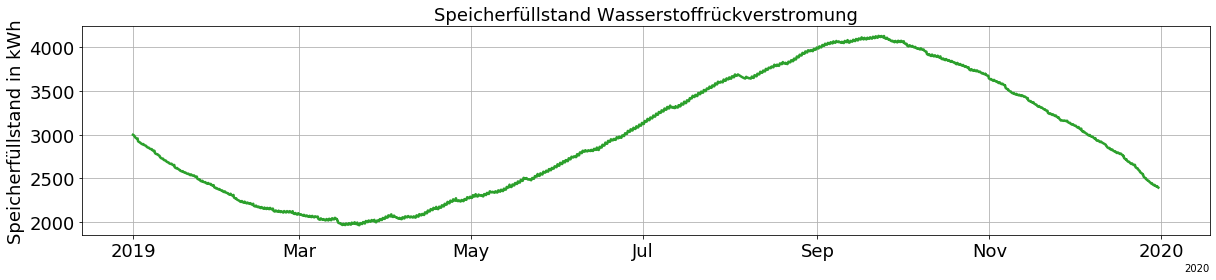

In [6]:
E_h2, P_elektrolyse_array, P_fuelcell_array=speicher.RFC_lastprofile(P_dif, 10000, 10000, eff_elektrolyse, eff_brennstoffzelle,  5000, 3000)
ax=vis.plot_timeline(year, E_h2,'Speicherfüllstand in kWh','Speicherfüllstand Wasserstoffrückverstromung',2)

### Batteriespeicher 10kW Ein/Ausspeicherleistung 10000kWh Kapazität

--> mehr oder weniger keine Limitierung bei Speicherleistung und Kapazität (vgl theoretischer Verlauf oben)
Startbefüllung des tanks wird auf 5000kWh eingestellt, da keine negativen Füllstände mehr zugelassen werden

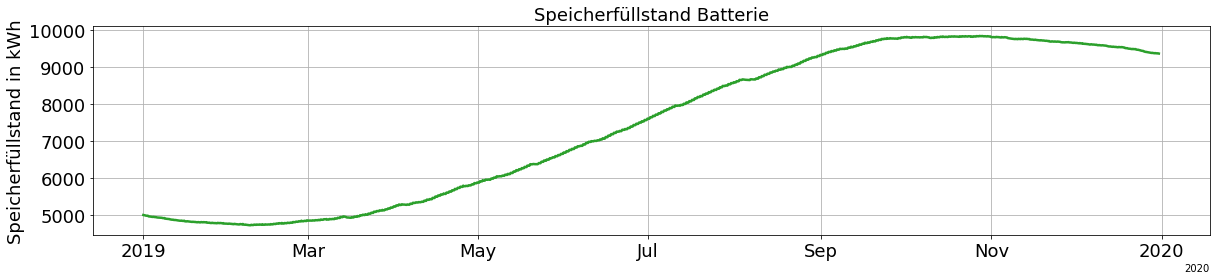

In [7]:
E_bat, P_battery_charge_array, P_battery_discharge_array=speicher.batterie_lastprofile(P_dif, 10000, 10000, eff_bat, 10000)
ax=vis.plot_timeline(year, E_bat,'Speicherfüllstand in kWh','Speicherfüllstand Batterie',2)



### Wasserstoffrückverstromung 2kW Elektrolyseur 1kW Brennstoffzelle 300kWh Kapazität

In [8]:
E_h2, P_elektrolyse_array, P_fuelcell_array=speicher.RFC_lastprofile(P_dif, 2000, 1000, eff_elektrolyse, eff_brennstoffzelle,  300, 0)
ax=vis.plot_timeline(year, E_h2,'Speicherfüllstand in kWh','Speicherfüllstand Wasserstoffrückverstromung mit 2kW Elektrolyseur',2)
ax=vis.plot_timeline(days, E_h2,'Speicherfüllstand in kWh','Speicherfüllstand Wasserstoffrückverstromung mit 2kW Elektrolyseur',2)
vis.save_to_tex('diagramm_speicherfuellstand',ax)
ax=vis.plot_timeline(days,P_elektrolyse_array,'Speicherleistung in W','Speicherleistung Wasserstoffrückverstromung mit 2kW Elektrolyseur')
vis.addtoplot_timeline(ax,days,P_fuelcell_array,['Brennstoffzelle','Elektrolyseur'],'upper right')
vis.save_to_tex('diagramm_speicherleistung',ax)

### Batteriespeicher 3kW Ein/Ausspeicherleistung 10kWh Kapazität

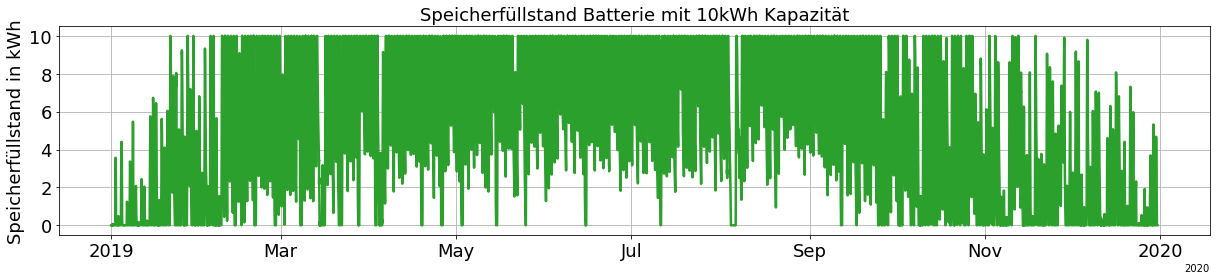

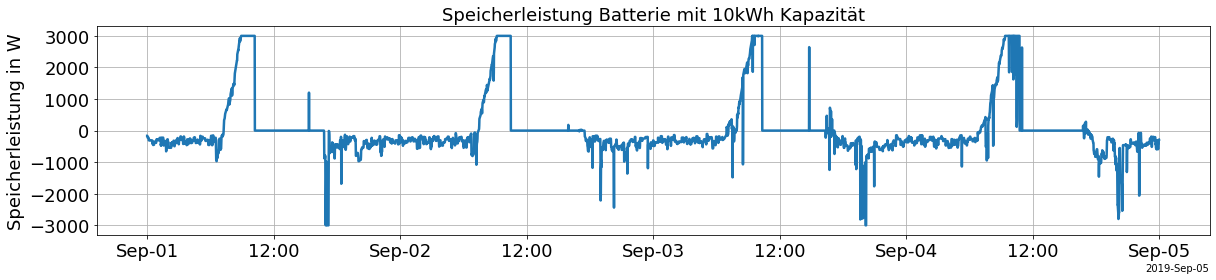

In [9]:
E_bat, P_battery_charge_array, P_battery_discharge_array=speicher.batterie_lastprofile(P_dif, 3000, 3000, eff_bat, 10)
ax=vis.plot_timeline(year, E_bat,'Speicherfüllstand in kWh','Speicherfüllstand Batterie mit 10kWh Kapazität',2)
ax=vis.plot_timeline(days, E_bat,'Speicherfüllstand in kWh','Speicherfüllstand Batterie mit 10kWh Kapazität',2)
ax=vis.plot_timeline(days, P_battery_charge_array-P_battery_discharge_array,'Speicherleistung in W','Speicherleistung Batterie mit 10kWh Kapazität')


### Hybridspeicher aus Batterie und Wasserstoffrückverstromung mit Auslegung ähnlich Picea von Homepowersolutions

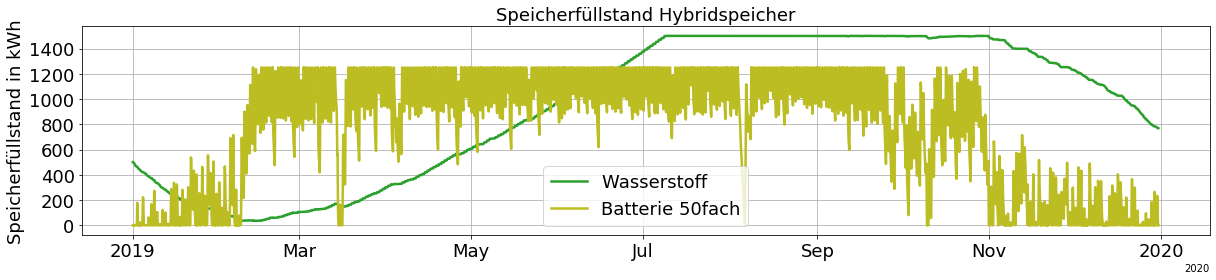

In [25]:
E_bat, P_battery_charge_array, P_battery_discharge_array=speicher.batterie_lastprofile(P_dif, 3000, 3000, eff_bat, 25)
#ax=vis.plot_timeline(days, P_battery_charge_array-P_battery_discharge_array,'Speicherleistung in W','Speicherleistung Batterie mit 10kWh Kapazität')
P_dif_new=P_dif-P_battery_charge_array+P_battery_discharge_array

E_h2, P_elektrolyse_array, P_fuelcell_array=speicher.RFC_lastprofile(P_dif_new, 3000, 1500, eff_elektrolyse, eff_brennstoffzelle,  1500, 500)
ax=vis.plot_timeline(year, E_h2,'Speicherfüllstand in kWh','Speicherfüllstand Hybridspeicher',2)
vis.addtoplot_timeline(ax, year, E_bat*50,['Wasserstoff','Batterie 50fach'],'best',8)
vis.save_to_tex('diagramm_speicherfuellstand_hybrid'+'_'+file_extension ,ax)